# Notebook to demonstrate basic usage of "object oriented NMF" package 

Demonstrate basic usage for my NMF package for binarized random data. 

# 1. load libraries, generate data

In [1]:
import sys

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/Users/amuratov/gits/EncodeNMF')


### import OONMF module from above path

In [55]:
import OONMF

### generate a random matrix of data. 

We binarize the random data by thresholding the values. In this case, I am simulating a relatively sparse data matrix (about 25% density)



In [5]:
def acquire_data(Dim1 = 20, Dim2=40, threshold=0.75):
    # fill in for whatever application
    pass

    data = np.random.rand(Dim1, Dim2)
    data = (data>threshold).astype(int)
    return data

In [6]:
data = acquire_data()

In [7]:
data.shape

(20, 40)

# 2. visualize data and perform non-negative matrix factorization

### quick visualization of random data

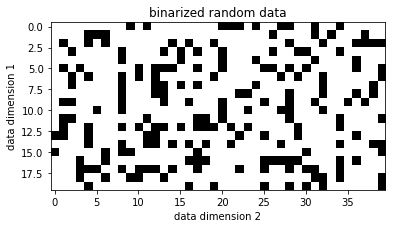

In [8]:

plt.imshow(data, cmap='binary')
plt.title('binarized random data')
plt.ylabel('data dimension 1')
plt.xlabel('data dimension 2')
plt.show()

#### now we create an object container for the NMF computation and results

#### in this example, I restrict the data to 5 NMF components 

In [9]:
NMFer = OONMF.NMFobject(5)


In [10]:
NMFer.performNMF(data)

starting NMF at  20190718_13:41:38
done with NMF at  20190718_13:41:38
returning reconstruction error


9.164560374063498

#### the NMFer object now contains the decomposed Basis and Mixture  matrices.

#### quick visualization below


In [56]:
NMFer.Basis.shape

(20, 5)

In [57]:
NMFer.Mixture.shape

(5, 40)

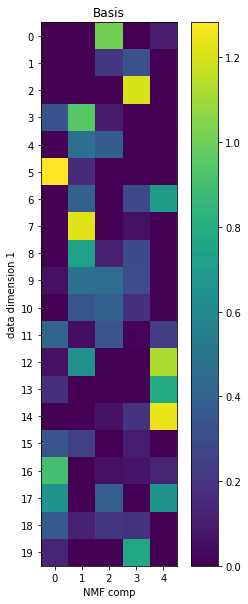

In [13]:
plt.figure(figsize=(5,10))
plt.imshow(NMFer.Basis)
plt.colorbar()
plt.yticks(np.arange(NMFer.Basis.shape[0]))
plt.xticks(np.arange(NMFer.Basis.shape[1]))
plt.xlabel('NMF comp')
plt.ylabel('data dimension 1')
plt.title('Basis')
plt.show()

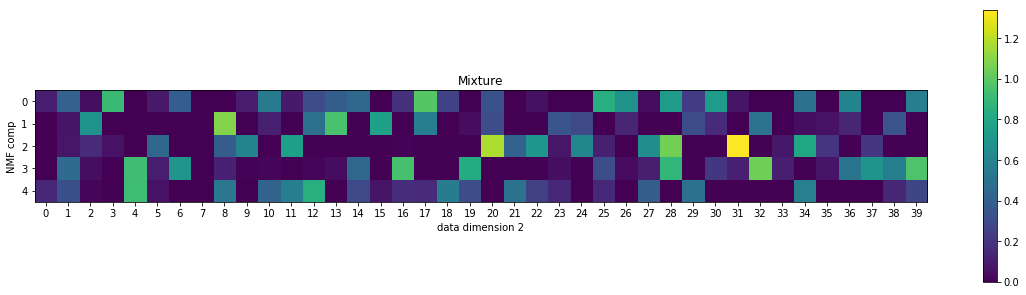

In [14]:
plt.figure(figsize=(20,5))
plt.imshow(NMFer.Mixture)
plt.yticks(np.arange(NMFer.Mixture.shape[0]))
plt.xticks(np.arange(NMFer.Mixture.shape[1]))
plt.ylabel('NMF comp')
plt.xlabel('data dimension 2')
plt.colorbar()
plt.title('Mixture')
plt.show()

### Both decomposed matrices are relatively sparse


# 3. Checking performance 

Using built in function to calculate "classification-like" error - e.g. precision, recall, etc. at a given decision boundary


In [18]:
[sample_PR, total_PR] = NMFer.precision_recall_curve(data)

In [19]:
total_PR.head()

,threshold,TP,FP,TN,FN
0,0.05,197,428,172,3
1,0.10,194,329,271,6
2,0.15,188,257,343,12
3,0.20,184,198,402,16
4,0.25,178,154,446,22


### now calculate error matrices (by hand in this case) 

In [25]:
total_PR['precision'] = total_PR['TP'] / (total_PR['TP'] + total_PR['FP'])
total_PR['recall'] = total_PR['TP'] / (total_PR['TP'] + total_PR['FN'])
total_PR['accuracy'] = (total_PR['TP'] + total_PR['TN']) / (total_PR['TP'] + total_PR['FP'] + total_PR['FN'] + total_PR['TN'])
total_PR['F1'] = 2*total_PR['precision']*total_PR['recall'] / (total_PR['precision']+total_PR['recall'])

In [24]:
total_PR.head(10)

,threshold,TP,FP,TN,FN,precision,recall,accuracy
0,0.05,197,428,172,3,0.315200,0.985,0.46125
1,0.10,194,329,271,6,0.370937,0.970,0.58125
2,0.15,188,257,343,12,0.422472,0.940,0.66375
3,0.20,184,198,402,16,0.481675,0.920,0.73250
4,0.25,178,154,446,22,0.536145,0.890,0.78000
5,0.30,160,120,480,40,0.571429,0.800,0.80000
6,0.35,148,80,520,52,0.649123,0.740,0.83500
7,0.40,134,55,545,66,0.708995,0.670,0.84875
8,0.45,127,37,563,73,0.774390,0.635,0.86250
9,0.50,112,23,577,88,0.829630,0.560,0.86125


### Calculate AUPRC - perhaps best metric of classification accuracy

In [26]:
AUPRC = np.trapz([1] + list(total_PR['recall'].values) + [0], [0] + list(total_PR['precision'].values) +[1])

In [27]:
AUPRC

0.8071411347678112

### AUPRC around 0.8. Not bad, considering we've compressed the data by a factor of ~3

now for some visualization for the reconstruction

<Figure size 432x288 with 0 Axes>

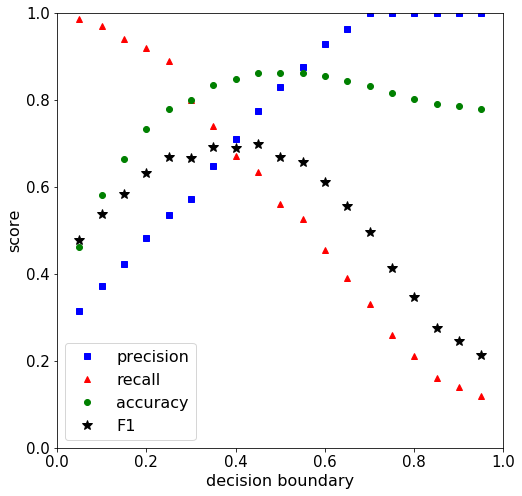

In [47]:
plt.clf()
plt.figure(figsize=(8,8))

plt.plot(total_PR['threshold'], total_PR['precision'], 'sb')
plt.plot(total_PR['threshold'], total_PR['recall'], '^r')
plt.plot(total_PR['threshold'], total_PR['accuracy'], 'og')
plt.plot(total_PR['threshold'], total_PR['F1'], '*k', ms=10)

plt.xlabel('decision boundary', fontsize=16)
plt.ylabel('score', fontsize=16)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=15)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=15)

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(['precision', 'recall', 'accuracy', 'F1'], fontsize=16)

plt.show()

### manually check reconstruction error and compute final statistic for accuracy

In [48]:
NMFer.build_reconstruction()

In [49]:
NMFer.Reconstruction.shape

(20, 40)

In [50]:
data.shape

(20, 40)

In [51]:
np.sum(np.square((NMFer.Reconstruction - data)))

83.98916684985488

In [52]:
np.sqrt(np.sum(np.square((NMFer.Reconstruction - data))))

9.164560374063498

### average accuracy per matrix element

In [54]:
1 - np.sqrt(np.sum(np.square((NMFer.Reconstruction - data)))) / (data.shape[0] * data.shape[1])

0.9885442995324206

more accurate than the classification-like accuracy would suggest - since in that case binarization of results increased error